### Discord Exfiltration - Anomaly Detection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

#### Dataset import and cleaning

In [3]:
# Read the CSV file (remove the index column)
discord_normal_observation_dataset = pd.read_csv('tests/alex_sample_features_m3_w[300]_s30.csv', delimiter=',')

# Display the first few rows of the dataframe
print("Big Normal Shape: ",discord_normal_observation_dataset.shape)
discord_normal_observation_dataset.head()

Big Normal Shape:  (1207, 23)


,mean_silence_duration,variance_silence_duration,mean_activity_duration,variance_activity_duration,30_quartile_activity_duration,60_quartile_activity_duration,90_quartile_activity_duration,tcp_upload_bytes_std_dev,tcp_download_bytes_std_dev,udp_upload_bytes_std_dev,...,udp_upload_bytes_mean,udp_download_bytes_mean,95_percentile_upload_bytes,98_percentile_upload_bytes,95_percentile_download_bytes,98_percentile_download_bytes,bytes_mean,bytes_std_dev,packets_mean,packets_std_dev
0,8.258,66.450,1.419,0.631,1.0,1.0,3.0,123.963,676.990,2305.174,...,470.280,2024.587,2686.65,7452.08,979.85,3755.04,2615.150,28680.764,3.880,29.391
1,10.680,78.138,1.375,0.651,1.0,1.0,2.7,123.314,677.065,2040.466,...,311.480,1830.363,200.50,4722.90,654.70,2588.92,2261.493,28557.129,3.237,29.007
2,10.920,82.714,1.125,0.193,1.0,1.0,1.0,121.537,673.114,1046.289,...,116.197,79.370,120.55,1385.36,416.45,701.62,307.027,2503.127,1.003,4.394
3,11.500,77.667,1.043,0.042,1.0,1.0,1.0,40.085,103.280,643.053,...,68.237,34.377,92.45,132.58,266.10,552.72,147.790,1067.640,0.693,2.708
4,12.043,122.737,1.045,0.043,1.0,1.0,1.0,39.886,97.910,643.053,...,68.237,34.377,91.00,132.58,248.15,552.72,145.800,1067.135,0.683,2.685


In [4]:
discord_small_normal_observation_dataset = pd.read_csv('tests/alex_small_sample_features_m3_w[300]_s30.csv', delimiter=',')

print("Small Normal Shape: ",discord_small_normal_observation_dataset.shape)
discord_small_normal_observation_dataset.head()

Small Normal Shape:  (510, 23)


,mean_silence_duration,variance_silence_duration,mean_activity_duration,variance_activity_duration,30_quartile_activity_duration,60_quartile_activity_duration,90_quartile_activity_duration,tcp_upload_bytes_std_dev,tcp_download_bytes_std_dev,udp_upload_bytes_std_dev,...,udp_upload_bytes_mean,udp_download_bytes_mean,95_percentile_upload_bytes,98_percentile_upload_bytes,95_percentile_download_bytes,98_percentile_download_bytes,bytes_mean,bytes_std_dev,packets_mean,packets_std_dev
0,9.214,102.740,1.500,0.821,1.0,1.0,2.3,57.244,140.173,1935.232,...,306.107,6954.563,921.60,3239.04,859.40,9706.62,7332.110,97236.783,7.913,89.738
1,8.467,95.582,1.586,1.001,1.0,1.0,3.0,58.611,152.980,2234.770,...,436.623,6992.230,2179.20,7357.46,1271.75,9706.62,7508.877,97234.209,8.337,89.752
2,7.844,93.319,1.581,0.953,1.0,1.0,3.0,59.766,148.388,2248.605,...,464.500,7002.963,2259.80,7357.46,1590.40,9706.62,7547.907,97232.045,8.417,89.748
3,6.861,79.120,1.514,0.878,1.0,1.0,2.6,72.385,152.524,2255.933,...,482.800,7008.413,2696.75,7357.46,1590.40,9706.62,7580.517,97230.125,8.513,89.742
4,6.944,77.164,1.429,0.816,1.0,1.0,2.0,57.021,155.762,2240.729,...,451.647,6994.777,2185.70,7357.46,1190.05,9706.62,7534.003,97232.741,8.400,89.745


In [5]:
print("Normal Big Capture Before Cleaning: ",discord_normal_observation_dataset.shape)
print("Normal Small Capture Before Cleaning: ",discord_small_normal_observation_dataset.shape)

# Remove all the rows with 'mean_activity_duration' == 0
discord_normal_observation_dataset = discord_normal_observation_dataset[discord_normal_observation_dataset['mean_activity_duration'] != 0]
discord_small_normal_observation_dataset = discord_small_normal_observation_dataset[discord_small_normal_observation_dataset['mean_activity_duration'] != 0]

print("\n\nNormal Big Capture After Cleaning", discord_normal_observation_dataset.shape)
print("Normal Small Capture After Cleaning", discord_small_normal_observation_dataset.shape)

Normal Big Capture Before Cleaning:  (1207, 23)
Normal Small Capture Before Cleaning:  (510, 23)


Normal Big Capture After Cleaning (1207, 23)
Normal Small Capture After Cleaning (510, 23)


#### Dataset Analysis

##### Distribution of the Mean Silence Duration

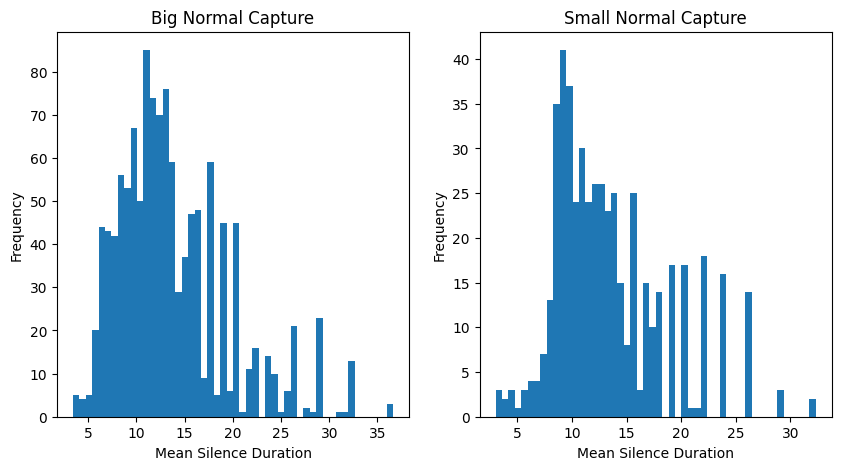

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(discord_normal_observation_dataset['mean_silence_duration'], bins=50)
plt.title('Big Normal Capture')
plt.xlabel('Mean Silence Duration')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(discord_small_normal_observation_dataset['mean_silence_duration'], bins=50)
plt.title('Small Normal Capture')
plt.xlabel('Mean Silence Duration')
plt.ylabel('Frequency')
plt.show()

##### Distribution of the Mean Activity Duration

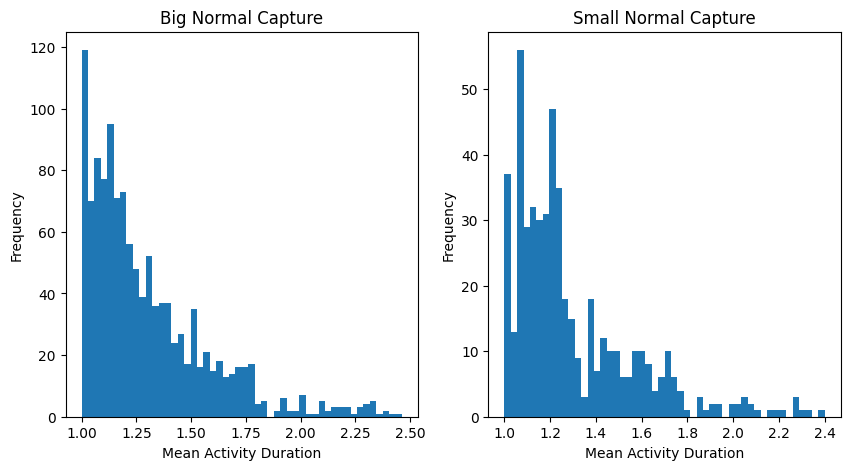

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(discord_normal_observation_dataset['mean_activity_duration'], bins=50)
plt.title('Big Normal Capture')
plt.xlabel('Mean Activity Duration')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(discord_small_normal_observation_dataset['mean_activity_duration'], bins=50)
plt.title('Small Normal Capture')
plt.xlabel('Mean Activity Duration')
plt.ylabel('Frequency')
plt.show()

##### Upload/Download Mean Ratio

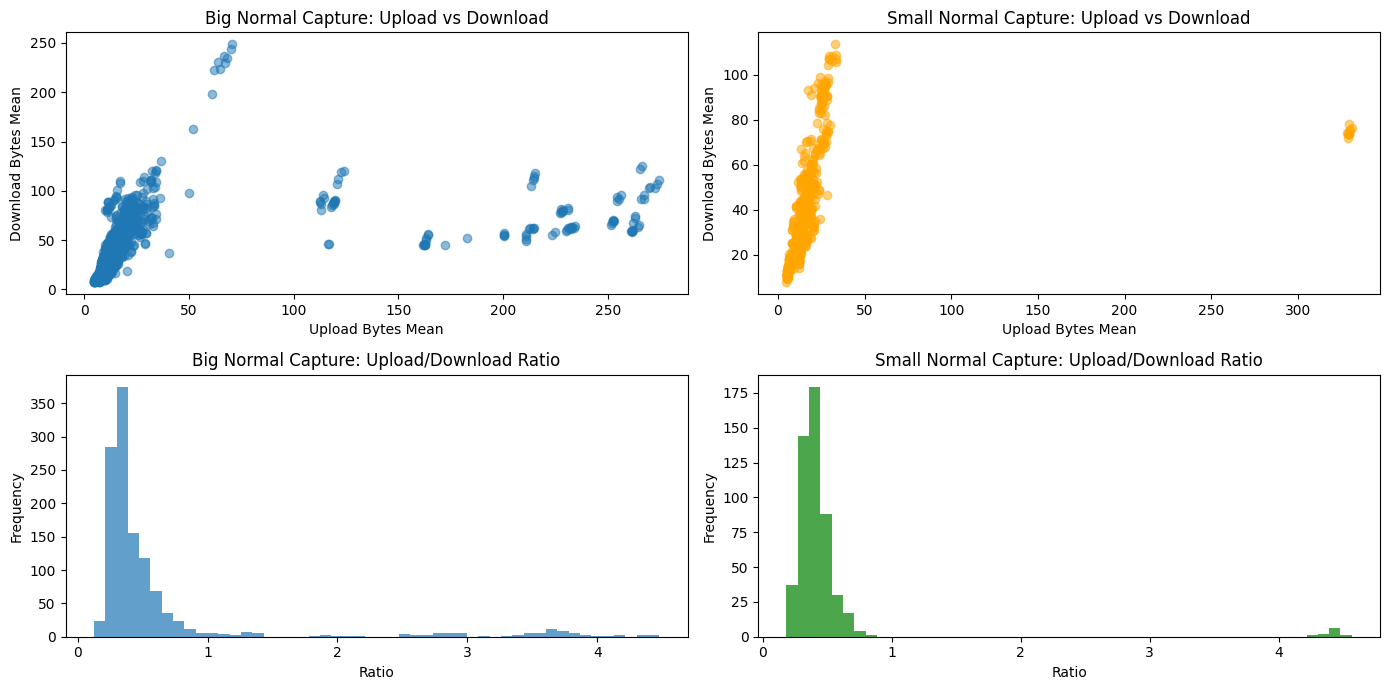

In [8]:
# Calculate upload/download ratios temporarily
normal_ratios = (discord_normal_observation_dataset['tcp_upload_bytes_mean'] / discord_normal_observation_dataset['tcp_download_bytes_mean'])
small_normal_ratios = (discord_small_normal_observation_dataset['tcp_upload_bytes_mean'] / discord_small_normal_observation_dataset['tcp_download_bytes_mean'])

plt.figure(figsize=(14, 7))

# Scatter Plot for Upload vs Download
plt.subplot(2, 2, 1)
plt.scatter(discord_normal_observation_dataset['tcp_upload_bytes_mean'],
            discord_normal_observation_dataset['tcp_download_bytes_mean'], alpha=0.5)
plt.title('Big Normal Capture: Upload vs Download')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

plt.subplot(2, 2, 2)
plt.scatter(discord_small_normal_observation_dataset['tcp_upload_bytes_mean'],
            discord_small_normal_observation_dataset['tcp_download_bytes_mean'], alpha=0.5, color='orange')
plt.title('Small Normal Capture: Upload vs Download')
plt.xlabel('Upload Bytes Mean')
plt.ylabel('Download Bytes Mean')

# Ratio Histograms
plt.subplot(2, 2, 3)
plt.hist(normal_ratios, bins=50, alpha=0.7)
plt.title('Big Normal Capture: Upload/Download Ratio')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(small_normal_ratios, bins=50, alpha=0.7, color='green')
plt.title('Small Normal Capture: Upload/Download Ratio')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Normalization and Split Process

In [9]:
# Perform normalization of the dataset (MinMaxScaler) - Use the training dataset to fit the scaler
scaler = MinMaxScaler()
scaler.fit(discord_normal_observation_dataset)

normalized_discord_normal_observation_dataset = scaler.fit_transform(discord_normal_observation_dataset)
normalized_discord_normal_small_observation_dataset = scaler.fit_transform(discord_small_normal_observation_dataset)

# Extract the features from the dataframe
train = normalized_discord_normal_observation_dataset
test = normalized_discord_normal_small_observation_dataset

#### Model Training

Models used:
- Autoencoder
- Isolation Forest
- One-Class SVM

##### One-Class SVM

In [10]:
# Initialize the OneClassSVM model (Unsupervised learning)
malicious_behavior_percentage = 0.0001
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=malicious_behavior_percentage)

# Train the model
ocsvm.fit(train)

# Test the model
predictions = ocsvm.predict(test)

##### Evaluation

In [11]:
# Display the number of normal and malicious observations
print("Normal observations: ", len(predictions[predictions == 1]))
print("Malicious observations: ", len(predictions[predictions == -1]))

# Display the percentage of malicious observations
print(f"Percentage of malicious observations: {len(predictions[predictions == -1]) / len(predictions) * 100:.2f}%")

Normal observations:  493
Malicious observations:  17
Percentage of malicious observations: 3.33%


##### Isolation Forest

In [24]:
# Train Isolation Forest
isolation_forest = IsolationForest(n_estimators=1000, contamination=0.01, random_state=42)
isolation_forest.fit(train)

# Predict anomalies
predictions = isolation_forest.predict(test)

##### Evaluation

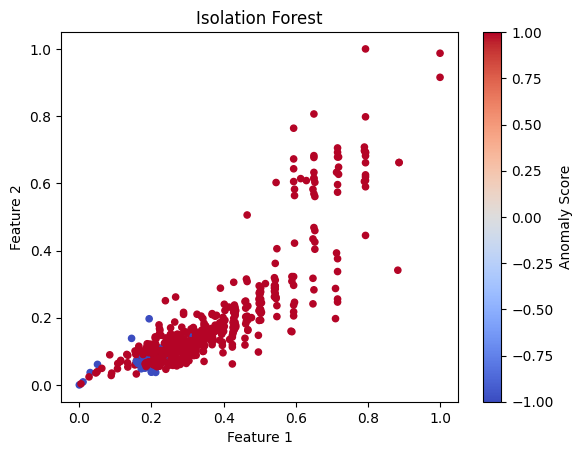

Normal observations:  474
Malicious observations:  36


In [27]:
# Visualize results
plt.scatter(test[:, 0], test[:, 1], c=predictions, cmap='coolwarm', s=20)
plt.title('Isolation Forest')
plt.colorbar(label='Anomaly Score')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Check the percentage of malicious observations
print("Normal observations: ", len(predictions[predictions == 1]))
print("Malicious observations: ", len(predictions[predictions == -1]))

##### Autoencoder

In [17]:
# Example for tabular data
input_dim = 23  # Number of features
encoding_dim = 5  # Latent space dimension

# Define the encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Define the decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Build the autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(train, train, epochs=100, batch_size=32, shuffle=False, validation_data=(test, test))

# Predict the anomalies
predictions = autoencoder.predict(test)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1990 - val_loss: 0.1720
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1850 - val_loss: 0.1575
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1676 - val_loss: 0.1393
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1458 - val_loss: 0.1197
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1226 - val_loss: 0.1018
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1006 - val_loss: 0.0868
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0816 - val_loss: 0.0754
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0664 - val_loss: 0.0671
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0546 - val_loss: 0.0611
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0457 - val_loss: 0.0568
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0391 - val_loss: 0.0535
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0

##### Evaluation

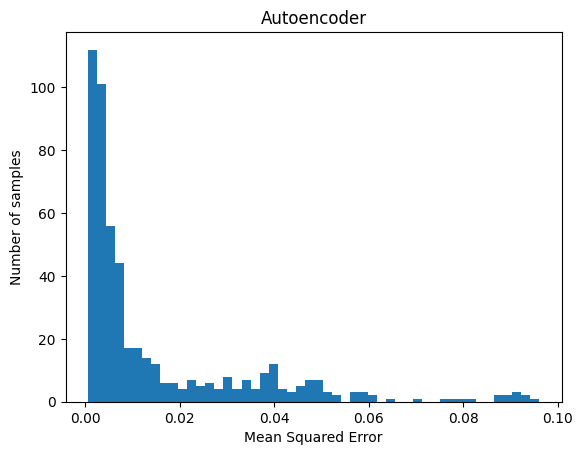

Number of anomalies:  0


In [18]:
# Calculate the mean squared error
mse = np.mean(np.power(test - predictions, 2), axis=1)

# Visualize the results
plt.hist(mse, bins=50)
plt.xlabel('Mean Squared Error')
plt.ylabel('Number of samples')
plt.title('Autoencoder')
plt.show()

# Check if there are any anomalies
threshold = 0.17
anomalies = mse > threshold
print("Number of anomalies: ", len(mse[anomalies]))